# Understanding the cost function sections

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit, transpile

sys.path.append('..')
from cost_sections import FitSecond, FitFirst, FitGeneral, FitSymmetric
from pnp_ansatze import make_pnp_ansatz
from cost_functions import global_cost_function, local_cost_function
from sequential_minimizer import SequentialVCMinimizer
from cost_sections import InversionGeneral, FitGeneral
from rttgen import CNOTBasedRtt
from cx_decomposition import cx_circuit
from model_circuits import single_step, two_steps

## Plotting function for cost sections

In [2]:
def plot_cost_section(cost_section, costs, title):
    fig, axes = plt.subplots(1, 1)
    
    thetas_curve = np.linspace(-2. * np.pi, 2. * np.pi, 201)
    plt.plot(thetas_curve, cost_section.fun(thetas_curve), label='section')

    plt.scatter(cost_section.thetas, costs, label='measured costs')

    theta_opt = cost_section.minimum()
    plt.scatter([cost_section.current], [cost_section.fun(cost_section.current)], c=['g'], label='current')
    plt.scatter([theta_opt], [cost_section.fun(theta_opt)], c=['r'], label='optimum')
    plt.legend()
    plt.title(title)

## Target circuit

In [3]:
num_sites = 4
aJ = 1.
am = 0.5
omegadt = 0.2

backend = Aer.get_backend('statevector_simulator')

In [4]:
qubit_pairs = list(zip(range(0, num_sites - 1), range(1, num_sites)))

rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)

two_step_circuit = two_steps(num_sites, aJ, am, omegadt, rtts=rtts, cxs=cxs)

target_circuit = QuantumCircuit(num_sites)
target_circuit.x([0, 2])
target_circuit.compose(two_step_circuit, inplace=True)

uncomputer = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)], first_layer_structure=[(0, 1), (2, 3)]).inverse()

compiler_circuit = target_circuit.compose(uncomputer)

num_params = len(compiler_circuit.parameters)

## Cost sections based on matrix inversion

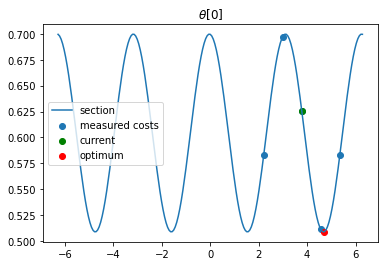

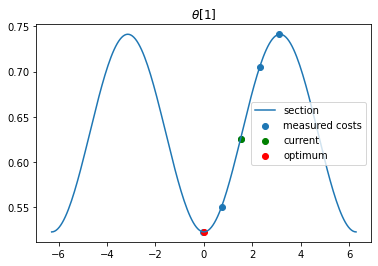

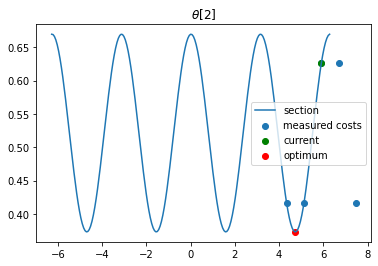

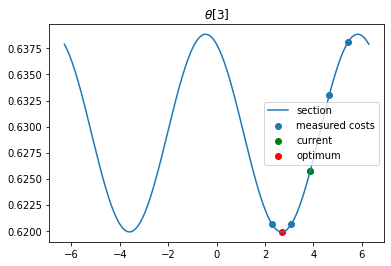

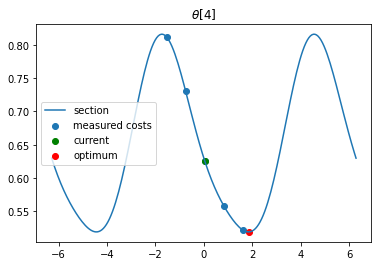

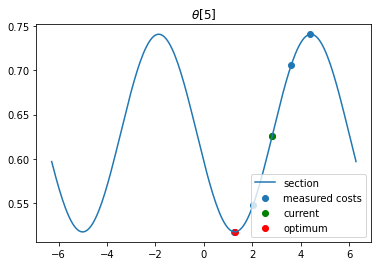

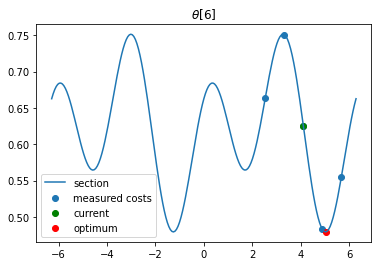

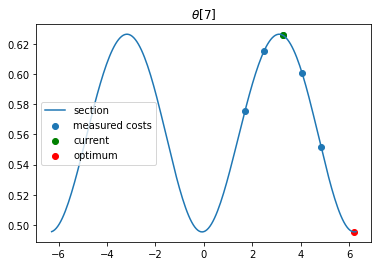

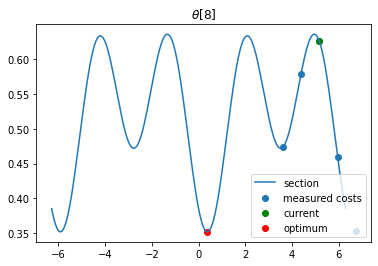

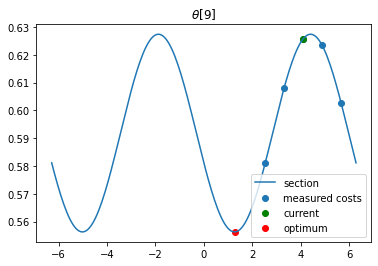

In [5]:
minimizer = SequentialVCMinimizer(compiler_circuit, local_cost_function, backend, shots=0, default_section=InversionGeneral)

param_val = np.random.rand(num_params) * 2. * np.pi

for iparam in range(num_params):
    cost_section, costs, _ = minimizer._calculate_cost_section(param_val, iparam)
    plot_cost_section(cost_section, costs, r'$\theta[{}]$'.format(iparam))

## Cost sections based on fit

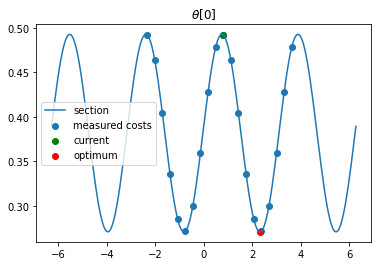

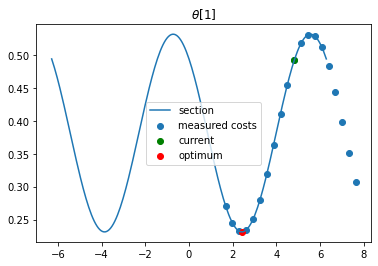

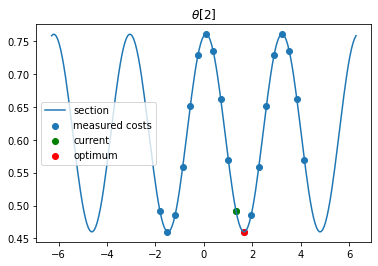

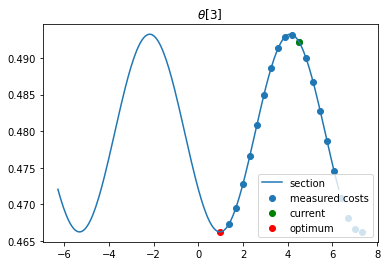

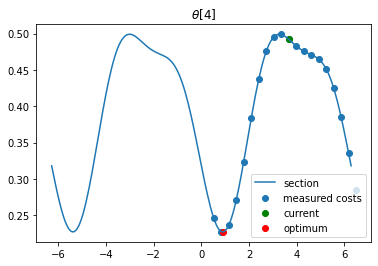

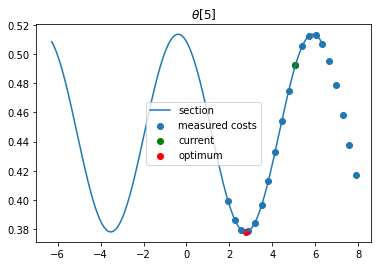

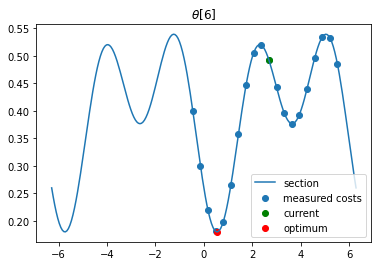

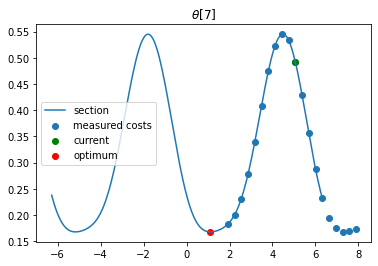

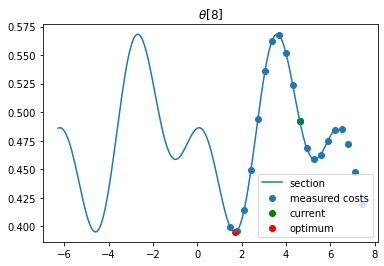

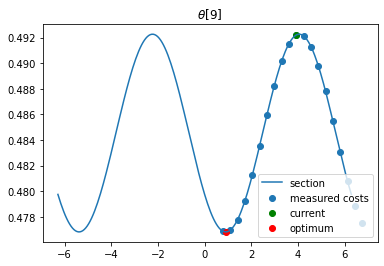

In [6]:
minimizer = SequentialVCMinimizer(compiler_circuit, local_cost_function, backend, shots=0, default_section=FitGeneral)

param_val = np.random.rand(num_params) * 2. * np.pi

for iparam in range(num_params):
    cost_section, costs, _ = minimizer._calculate_cost_section(param_val, iparam)
    plot_cost_section(cost_section, costs, r'$\theta[{}]$'.format(iparam))

## Notes

The plots above strongly suggests that sections along $\theta[0], \theta[1], \theta[2], \theta[3], \theta[5]$ have simpler shapes than the general form $b_0 \sin 2\theta + b_1 \cos 2\theta + b_2 \sin \theta + b_3 \cos \theta + b_4$. In fact, it can be calculated that $\theta[0]$ and $\theta[2]$ sections only depend on $\cos 2\theta, \sin 2\theta, \text{const}$ and the others on $\cos \theta, \sin \theta, \text{const}$.  

Moreover, at the global minimum, all sections reduce to symmetric forms that depend on $\cos 2(\theta - \theta_{\text{opt}}), \cos (\theta - \theta_{\text{opt}}), \text{const}$:

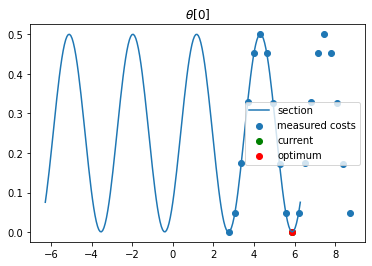

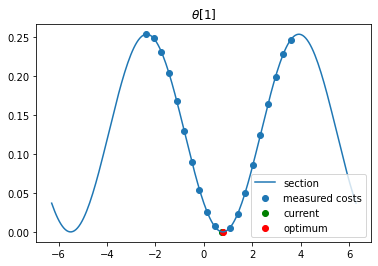

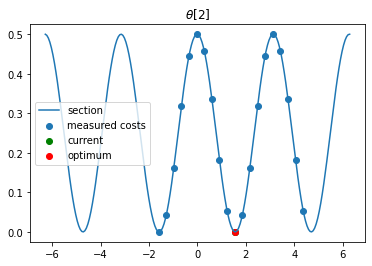

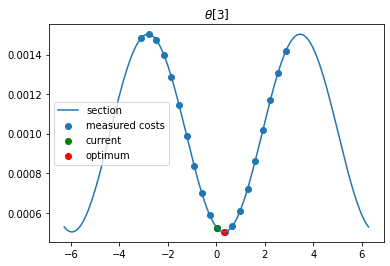

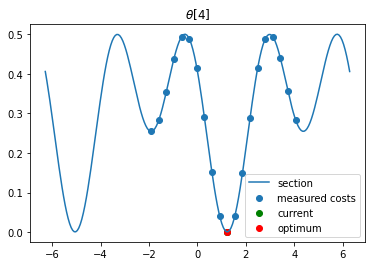

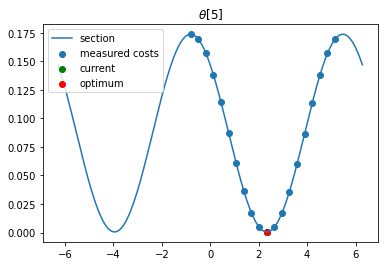

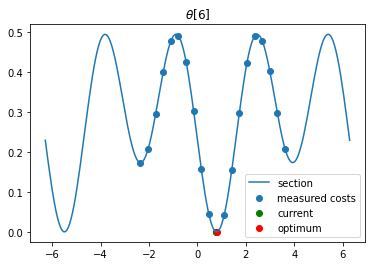

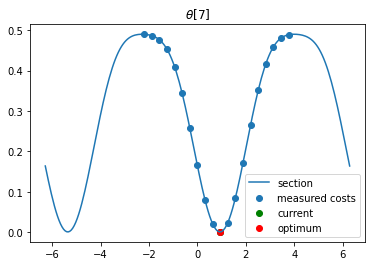

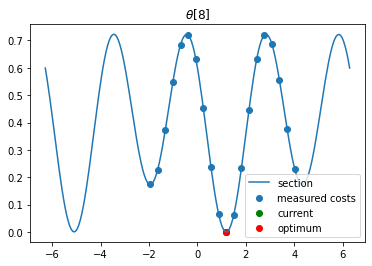

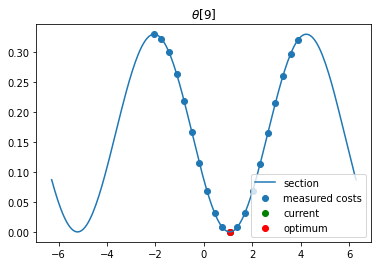

In [8]:
param_val = np.array([5.88840611, 0.76283482, 1.53601305, 0.0330668, 1.22698455, 2.32726878, 0.78539816, 0.93775626, 1.1851489, 1.07022145])

for iparam in range(num_params):
    cost_section, costs, _ = minimizer._calculate_cost_section(param_val, iparam)
    plot_cost_section(cost_section, costs, r'$\theta[{}]$'.format(iparam))